# Libraries

In [1]:
from functions import *

In [2]:
# import numpy as np
# import matplotlib.pyplot as plt

# matriz = np.zeros((5,5), dtype=np.uint8)
# matriz[1:4, 1:4] = 255

# np.savetxt("matriz.txt", matriz, fmt='%d')  # Salva como texto

# # Carrega de volta
# matriz_carregada = np.loadtxt("matriz.txt", dtype=np.uint8)

# plt.imshow(matriz_carregada, cmap="gray")
# plt.show()

# Gross section generator

estou aqui:  67486 (2500, 2500)


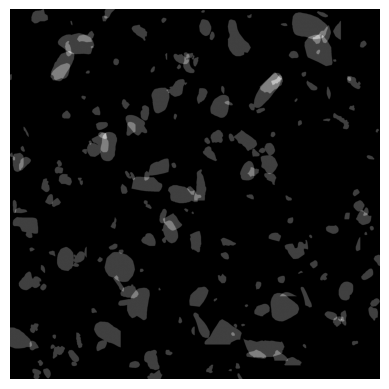

NameError: name 'canvas' is not defined

In [3]:
generate_canvas_from_json("dataset_contours_aggregate_by_patch.json", (2500, 2500), 200)